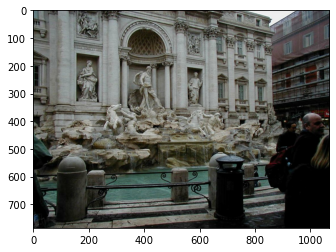

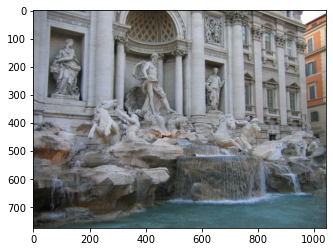

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pyrobustac
from time import time

img1 = cv2.cvtColor(cv2.imread('../build/data/00046350_1877865767.jpg'), cv2.COLOR_BGR2RGB)
img2 = cv2.cvtColor(cv2.imread('../build/data/00325388_2471426448.jpg'), cv2.COLOR_BGR2RGB)
K1 = np.loadtxt('../build/data/00046350_1877865767.K')
K2 = np.loadtxt('../build/data/00325388_2471426448.K')
plt.imshow(img1)
plt.figure()
plt.imshow(img2)

In [2]:
#We will detect ORB features and match them with cross-check test
srcPts, dstPts, affines = pyrobustac.extractACs('../build/data/00046350_1877865767.jpg', 
                                                '../build/data/00325388_2471426448.jpg')

print(srcPts.shape[0], 'affine correspondences are found.')

860 affine correspondences are found.


In [3]:
#Now, some visualization from OpenCV tutorial
#https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_feature_homography/py_feature_homography.html
#We will draw correspondences found and the geometric transformation between the images.
from copy import deepcopy
def decolorize(img):
    return  cv2.cvtColor(cv2.cvtColor(img,cv2.COLOR_RGB2GRAY), cv2.COLOR_GRAY2RGB)
def draw_matches(kps1, kps2, img1, img2, mask):
    
    n = kps1.shape[0]
    sourceKeypoints = [cv2.KeyPoint(kps1[i][0], kps1[i][1], 0) for i in np.arange(n)]
    destinationKeypoints = [cv2.KeyPoint(kps2[i][0], kps2[i][1], 0) for i in np.arange(n)]
    tentatives = [cv2.DMatch(i, i, 0) for i in np.arange(n)]
    
    matchesMask = mask.ravel().tolist()
    
    # Blue is estimated, green is ground truth homography
    draw_params = dict(matchColor = (255,255,0), # draw matches in yellow color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
    img_out = cv2.drawMatches(decolorize(img1),sourceKeypoints,decolorize(img2),destinationKeypoints,tentatives,None,**draw_params)
    plt.figure(figsize = (12,8))
    plt.imshow(cv2.cvtColor(img_out, cv2.COLOR_BGR2RGB))
    plt.show() 
    return

In [4]:
img1.shape

(785, 1069, 3)

562.0 inliers found
0.010970830917358398  sec cv2
860.0 inliers found
0.008976221084594727  sec gc-ransac with affine correspondences


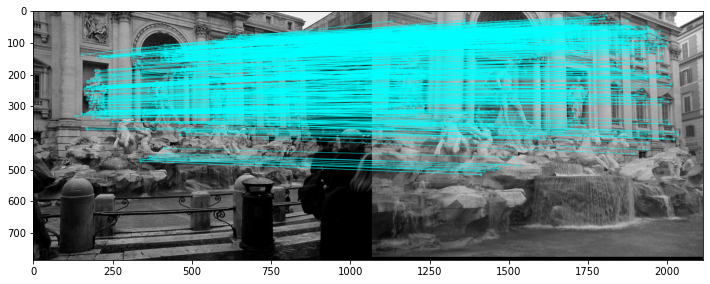

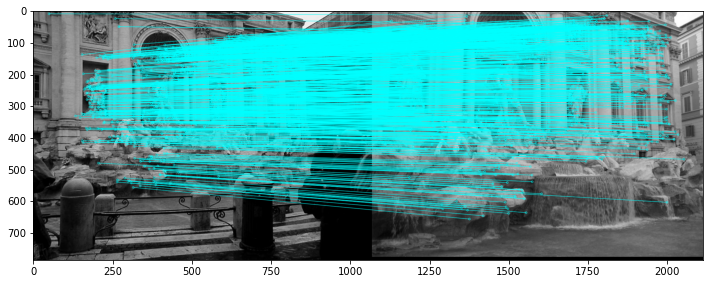

In [5]:
def verify_cv2(kps1, kps2, K1, K2):
    # Normalize the threshold
    threshold = 0.75
    avgDiagonal = (K1[0][0] + K1[1][1] + K2[0][0] + K2[1][1]) / 4; 
    normalizedThreshold = threshold / avgDiagonal;
            
    # Normalize the point coordinates
    normalizedSourcePoints = cv2.undistortPoints(np.expand_dims(kps1, axis=1), cameraMatrix=K1, distCoeffs=None)
    normalizedDestinationPoints = cv2.undistortPoints(np.expand_dims(kps2, axis=1), cameraMatrix=K2, distCoeffs=None)
    
    # Estimate the essential matrix from the normalized coordinates
    # using the normalized threshold.
    E, mask = cv2.findEssentialMat(normalizedSourcePoints, 
                                   normalizedDestinationPoints, 
                                   focal=1.0, 
                                   pp=(0., 0.),
                                   method=cv2.RANSAC, 
                                   prob=0.99,
                                   threshold=normalizedThreshold)

    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return E, mask

def verify_pygcransac(kps1, kps2, affines, K1, K2, h1, w1, h2, w2):
    E, mask = pyrobustac.findEssentialMat(
        np.ascontiguousarray(kps1), 
        np.ascontiguousarray(kps2), 
        np.ascontiguousarray(affines), 
        np.ascontiguousarray(K1), 
        np.ascontiguousarray(K2), 
        h1, w1, h2, w2, 
        0.75,
        0.99,
        0.0)
    print (deepcopy(mask).astype(np.float32).sum(), 'inliers found')
    return E, mask

t=time()
cv2_H, cv2_mask = verify_cv2(srcPts, dstPts, K1, K2)
print (time()-t, ' sec cv2')
t=time()
ac_H, ac_mask = verify_pygcransac(srcPts, dstPts, affines, np.linalg.inv(K1), np.linalg.inv(K2), img1.shape[0],img1.shape[1], img2.shape[0], img2.shape[1])
print (time()-t, ' sec gc-ransac with affine correspondences')

draw_matches(srcPts, dstPts, img1, img2, cv2_mask)
draw_matches(srcPts, dstPts, img1, img2, ac_mask)
